# 深度学习实验六:大模型迁移学习

本次实验练习将大规模数据集上训练的模型迁移到新的任务上。

In [2]:
name = '王浩南'#填写你的姓名
sid = 'E02014154'#填写你的学号

print('姓名:%s, 学号:%s'%(name, sid))

姓名:王浩南, 学号:E02014154


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 1. 准备数据

本次实验的训练样本存放在磁盘的./data./flower_photos目录中，其中train目录中是训练样本，test目录中是测试样本。

请使用```torchvision.datasets.ImageFolder```类构造样本集。

本实验将ImageNet上训练的resnet模型迁移到本实验任务中，因此需要对图像做以下Normalize预处理：像素均值为$[0.485,0.456,0.406]$,标准差为$[0.229,0.224,0.225]$.resnet模型的输入图像尺寸为$224\times224$，请选择合适的增广变换，将原始样本变换为同样尺寸的训练样本。

In [4]:
from torchvision import datasets,transforms

In [5]:
#在下面构造合适的变换
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
#构造训练集和测试集dataset
data_path1 = './data/flower_photos/train'
data_path2 = './data/flower_photos/test'
flower_train = datasets.ImageFolder(data_path1, transform = data_transform)#一行代码 
flower_test = datasets.ImageFolder(data_path2, transform = data_transform) #一行代码

In [7]:
flower_train

Dataset ImageFolder
    Number of datapoints: 3118
    Root location: ./data/flower_photos/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

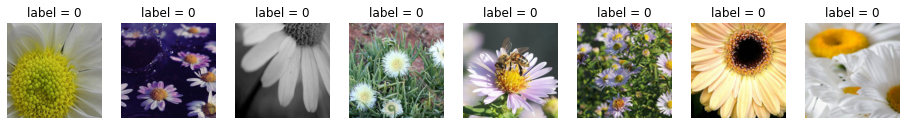

In [8]:
#显示图像样本
flower_iter = iter(flower_test)
plt.figure(figsize = [16,10])
for i in range(8):
    im,label = next(flower_iter)

    im = im.permute((1,2,0))
    im = im * torch.tensor([[[0.229,0.224,0.225]]]) + torch.tensor([[[0.485,0.456,0.406]]])
    plt.subplot(1,8,i+1)
    plt.imshow(im)
    plt.title('label = %d'%(label))
    plt.axis('off')
    
plt.show()

# 2. 使用ResNet迁移学习

将Resnet用于本实验的花卉识别。PyTorch中提供了若干ResNet模型及其预训练权重，其中的预训练权重可以从以下地址下载：

```
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}
```
resnet网络结构可以参考以下页面：https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html

本次实验根据你的电脑性能，可以选择resnet18/34/50作为迁移模型。

In [9]:
import torchvision.models as models

In [10]:
#在下面添加代码，实现一个模型,注意该模型中使用resnet作为特征提取器，并添加你自己设计的分类网络用于图像分类
#请自行选择resnet中用于微调的层
#注意要加载预训练权重

class FlowerClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        #构造一个ResNet50模型，并且使用本地磁盘上的预训练权值参数
        self.extractor = models.resnet50(pretrained = False)
        state_dict = torch.load('resnet50.pth')
        self.extractor.load_state_dict(state_dict=state_dict)
        
        '''
        #列出网络的各个层参数名称
        for name, _ in self.extractor.named_parameters():
            print(name)
        '''
        #假设只需要训练layer4的权值，那么可以把layer1~layer3的参数的梯度属性置为False，如下方代码所示
        exclude_layers = ['layer1', 'layer2', 'layer3']#这些层不训练
        for name, param in self.extractor.named_parameters():
            for layer in exclude_layers:
                if name.startswith(layer):
                    param.requires_grad = False
                    break

        #改造分类层
        featureSize = self.extractor.fc.in_features
        self.extractor.fc = nn.Linear(in_features=featureSize, out_features=num_classes)

    def forward(self, x):

        # 使用 ResNet50 提取图像特征
        logits = self.extractor(x)

        return logits

In [11]:
#测试FlowerClassifier类
X = torch.rand((10,3,224,224),dtype = torch.float32)
net = FlowerClassifier(num_classes = 5)
Y = net(X)
print(Y.shape)

d:\Anaconda\envs\My_Torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\My_Torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([10, 5])


In [12]:
#输出模型
print(net)

FlowerClassifier(
  (extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [13]:
%pip install -i https://pypi.tuna.tsinghua.edu.cn/simple torchsummary

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [14]:
from torchsummary import summary

summary(net.cuda(), input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# 3.训练模型

# 3.1 第一步，构造加载器，用于加载上面定义的数据集

In [15]:
#在下面构造训练集和测试集加载器
#自行设定batch_size大小

train_loader = torch.utils.data.DataLoader(dataset=flower_train,
                                               batch_size=32,
                                               shuffle=True,
                                               num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=flower_test,
                                               batch_size=32,
                                               shuffle=True,
                                               num_workers=2)

In [16]:
imgs,labels = next(iter(train_loader))

In [17]:
imgs.shape

torch.Size([32, 3, 224, 224])

In [18]:
labels.shape

torch.Size([32])

# 3.2 第二步，训练模型

注意：训练卷积神经网络时，网络的输入是四维张量，尺寸为$N\times C \times H \times W$，分别表示张量

In [19]:
def Train(model, loader, epochs, lr = 0.001):
    epsilon = 1e-7
    
    model = model.cuda()
    model.train()
    
    optimizer = optim.RMSprop(model.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    
    loss0 = 0
    for epoch in range(epochs):
        for it,(imgs, labels) in enumerate(loader):
            #1. zero_grads
            optimizer.zero_grad()
            imgs, labels = imgs.cuda(), labels.cuda()

            #2. F.P.
            logits = model(imgs)
            
            #3. Loss
            loss1 = loss(logits,labels)
            
#             if(abs(loss1.item() - loss0)<epsilon):
#                 break
                
            loss0 = loss1.item()
                
            if it%10==0:
                print('epoch %d, iter %d, loss = %f\n'%(epoch,it,loss1.item()))
                
            #4. B.P.
            loss1.backward()
            
            #5. G.D.
            optimizer.step()
            
    return model            

In [20]:
model = FlowerClassifier(5)

model = Train(model, test_loader, 10)

epoch 0, iter 0, loss = 1.697416

epoch 0, iter 10, loss = 1.261097

epoch 1, iter 0, loss = 2.176219

epoch 1, iter 10, loss = 0.886417

epoch 2, iter 0, loss = 0.557351

epoch 2, iter 10, loss = 0.601116

epoch 3, iter 0, loss = 0.457151

epoch 3, iter 10, loss = 0.801494

epoch 4, iter 0, loss = 0.447177

epoch 4, iter 10, loss = 0.267140

epoch 5, iter 0, loss = 0.496665

epoch 5, iter 10, loss = 0.249013

epoch 6, iter 0, loss = 0.454826

epoch 6, iter 10, loss = 0.092028

epoch 7, iter 0, loss = 0.325584

epoch 7, iter 10, loss = 0.182739

epoch 8, iter 0, loss = 0.199446

epoch 8, iter 10, loss = 0.142124

epoch 9, iter 0, loss = 0.726915

epoch 9, iter 10, loss = 0.174345



In [21]:
#在下面添加代码，保存训练结果
state_dict = model.state_dict()
torch.save(state_dict,'my_model.pth')

# 3.3 第三步，测试模型

In [22]:
#编写模型测试过程
def Evaluate(model, loader):
    model.eval()
    correct = 0
    counts = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            logits = model(imgs)
            yhat = logits.argmax(dim = 1)
            correct = correct + (yhat==labels).sum().item()
            counts = counts + imgs.size(0)
    
    accuracy = correct / counts
    
    return accuracy

In [23]:
#在下面统计训练集与测试集的识别准确率

train_acc = Evaluate(model,train_loader)#一行代码
print('Training Accuracy = %f'%(train_acc))

test_acc = Evaluate(model,test_loader)#一行代码
print('Test Accuracy = %f'%(test_acc))

Training Accuracy = 0.713598
Test Accuracy = 0.811594


根据上述准确率指标，判断你的模型是否发生过拟合或欠拟合？在下面写出你的分析。



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

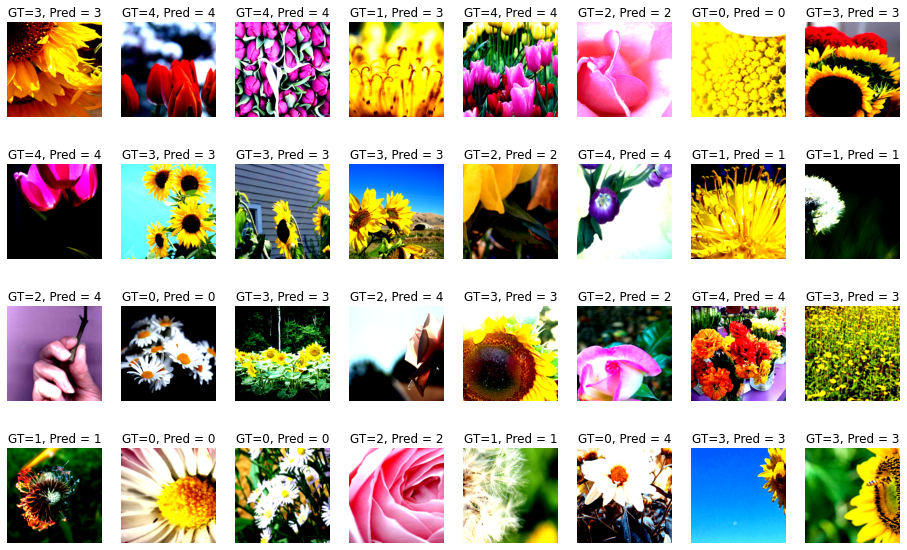

In [24]:
#展示部分预测结果
imgs,labels  = next(iter(test_loader))
imgs, labels = imgs.cuda(), labels.cuda()

logits = model(imgs)

imgs, labels = imgs.cpu(), labels.cpu()

yhat = logits.argmax(dim = 1)
imgs = imgs.permute((0,2,3,1))
plt.figure(figsize = (16,10))
for i in range(imgs.size(0)):
    plt.subplot(4,8,i+1)
    plt.imshow(imgs[i]/2+0.5,cmap = 'gray')
    plt.axis('off')
    plt.title('GT=%d, Pred = %d'%(labels[i],yhat[i]))
    
plt.show()

## 3.4 错误分析(选做)

### 3.4.1 统计混淆矩阵

In [25]:
#在下面统计你的模型在训练集/测试集上的混淆矩阵


### 3.4.2 错误样本分析

In [26]:
#在下面输出识别效果最差的类别的错误结果，并试着总结错误规律


经过对上述错误样本的分析，你觉得错误可能原因是什么？如何改进样本/模型？

